In [2]:
import os
import sys
sys.path.append("../")
import csv
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import settings
from process_sentinel3 import OLCIdata, OLCIdataGenerator

### Define variables

In [3]:
DATA_PATH = settings.processed_data_path
algae_gt_path = os.path.join(settings.final_data_path, "algae_gt.csv")

#contorno interno lat/lon
INTERNAL_CONTOUR = [[-34.85044049, -55.05341557], [-34.85254593, -55.06282895], [-34.84523452, -55.07215948], 
                    [-34.84214073, -55.08336897], [-34.83733203, -55.08595825], [-34.830501, -55.07932854], 
                    [-34.82322889, -55.07377278], [-34.81443658, -55.06745663], [-34.80518264, -55.06063834], 
                   [-34.79828906, -55.05565486], [-34.79200075, -55.04700809], [-34.80233605, -55.04418996],
                   [-34.81042967, -55.04493995], [-34.82011843, -55.04664643], [-34.82953074, -55.04855582],
                   [-34.83996726, -55.0500401], [-34.85044049, -55.05341557]]
# lon/lat
INTERNAL_CONTOUR_2 = [[coord[1], coord[0]] for coord in INTERNAL_CONTOUR]

## Read CSV containing GT into a DataFrame

In [5]:
algae_df = pd.read_csv(algae_gt_path)
algae_df["date"] = pd.to_datetime(algae_df["date"])
algae_df["date"] = algae_df["date"].dt.date
all_gt_dates = algae_df.date.unique().tolist()
#print(all_gt_dates)
print(f"Total dates in GT: {len(all_gt_dates)}")
algae_df[algae_df["location"].isin(["TA", "SAUCE NORTE", "SAUCE SUR"])]

Total dates in GT: 243


,date,location,fico,chl,label
2,2015-12-30,SAUCE NORTE,4282.50,7.50,No Bloom
3,2015-12-30,SAUCE SUR,5388.00,7.50,No Bloom
8,2016-01-07,SAUCE SUR,14982.50,12.25,Bloom
11,2016-01-07,SAUCE NORTE,11768.00,10.35,Bloom
14,2016-01-13,SAUCE NORTE,12766.00,9.70,Bloom
...,...,...,...,...,...
685,2020-10-31,TA,1083.00,NaN,No Bloom
686,2020-11-01,TA,47.00,NaN,No Bloom
687,2020-11-02,TA,5.96,NaN,No Bloom
688,2020-11-05,TA,9.06,NaN,No Bloom


### Satellite availability

In [7]:
first_sentinel3_date = "2018-11-01"
first_sentinel3_date = datetime.strptime(first_sentinel3_date, "%Y-%m-%d").date()
gt_last_date = all_gt_dates[-1]
gt_first_date = all_gt_dates[0]

In [5]:
data_generator = OLCIdataGenerator(DATA_PATH, dates_list=all_gt_dates, skip_invalid=False,
                                  mask_coordinates=INTERNAL_CONTOUR_2)

data_generator_skip_invalid = OLCIdataGenerator(DATA_PATH, dates_list=all_gt_dates, skip_invalid=True,
                                  mask_coordinates=INTERNAL_CONTOUR_2)

In [8]:
fico_df_after_s3b = algae_df[algae_df["date"] >= first_sentinel3_date]

s3_all = list(set([d.date.date() for d in data_generator \
                               if d.date.date() >= first_sentinel3_date and d.date.date() <= gt_last_date]))

satellite_acquisition_rate = round(len(s3_all)/len(fico_df_after_s3b["date"].unique()),2)
print(f"Sentinel-3 acquisition rate: {satellite_acquisition_rate}")

s3_skip_invalid = list(set([d.date.date() for d in data_generator_skip_invalid \
                                if d.date.date() >= first_sentinel3_date and d.date.date() <= gt_last_date]))
satellite_acquisition_clear =  round(len(s3_skip_invalid)/len(fico_df_after_s3b["date"].unique()), 2)
print(f"Sentinel-3 acquisition without clouds: {satellite_acquisition_clear}")

Sentinel-3 acquisition rate: 1.0
Sentinel-3 acquisition without clouds: 0.34


## NDVI validation

In [8]:
chl_top_days = algae_df[algae_df["date"] >= first_sentinel3_date].sort_values(by="chl", ascending=False)
chl_top_days = chl_top_days[chl_top_days["location"].isin(["SAUCE NORTE", "SAUCE SUR"])].head(10)

chl_bottom_days = algae_df[algae_df["date"] >= first_sentinel3_date].sort_values(by="chl")
chl_bottom_days = chl_bottom_days[chl_bottom_days["location"].isin(["SAUCE NORTE", "SAUCE SUR"])].head(10)

In [9]:
chl_top_days

,date,location,fico,chl,label
415,2019-12-23,SAUCE SUR,6423.5,23.15,No Bloom
419,2019-12-23,SAUCE NORTE,5427.5,22.75,No Bloom
446,2020-01-16,SAUCE SUR,3496.0,17.70,No Bloom
432,2020-01-07,SAUCE SUR,19290.0,14.10,Bloom
609,2020-04-23,SAUCE SUR,23909.0,11.80,Bloom
273,2018-12-13,SAUCE NORTE,1883.0,11.60,No Bloom
521,2020-03-04,SAUCE SUR,1819.0,11.20,No Bloom
571,2020-04-04,SAUCE SUR,45380.0,11.10,Bloom
568,2020-04-04,SAUCE NORTE,53100.0,11.05,Bloom
370,2019-04-12,SAUCE NORTE,2364.0,10.80,No Bloom


2019-12-23
2020-01-07
2020-01-16
2020-03-04
2020-04-04


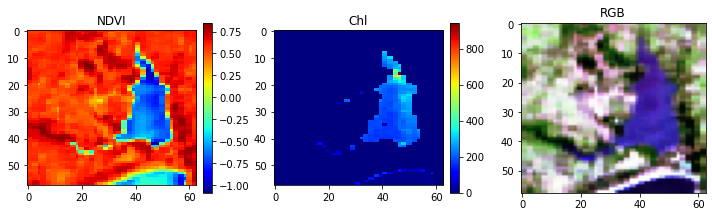

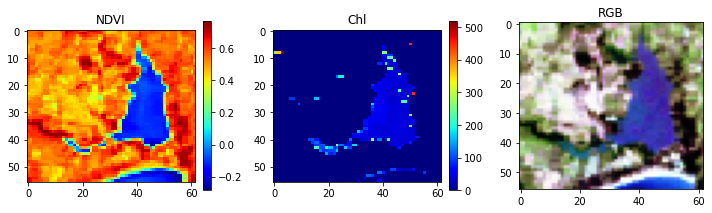

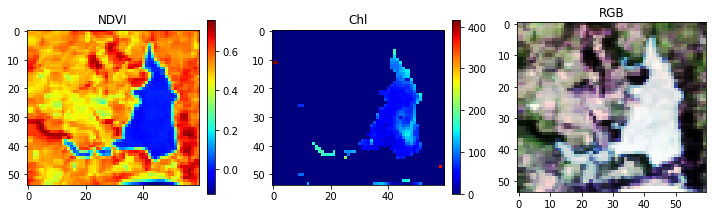

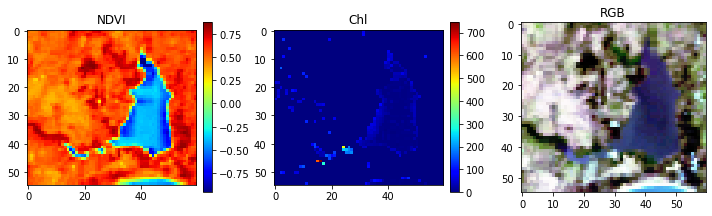

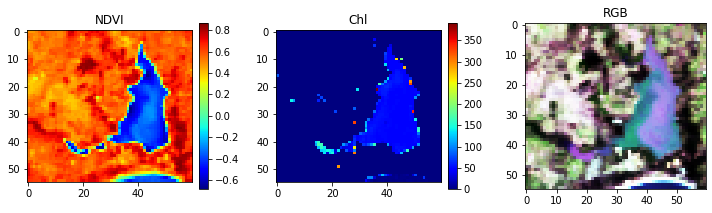

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

data_generator_chl_top = OLCIdataGenerator(DATA_PATH, dates_list=chl_top_days["date"].tolist(), skip_invalid=True)

date = ""
for olci_data in data_generator_chl_top:
    if olci_data.date.date() == date and np.count_nonzero(olci_data.duplicated) > 1000:
        continue
        
    date =olci_data.date.date()
    print(date)
    fig = plt.figure(figsize=(10,20))
    
    fig.add_subplot(131).title.set_text("NDVI")
    min_ndvi = np.amin(olci_data.mph.NDVI)
    max_ndvi = np.amax(olci_data.mph.NDVI)
    plt.imshow(olci_data.mph.NDVI, cmap='jet', interpolation='none',
              vmin=min_ndvi, vmax=max_ndvi)
    plt.colorbar(fraction=0.046, pad=0.04)    
    
    fig.add_subplot(132).title.set_text("Chl")
    min_chl = np.amin(olci_data.mph.chl)
    max_chl = np.amax(olci_data.mph.chl)
    plt.imshow(olci_data.mph.chl, cmap='jet', interpolation='none',
              vmin=min_chl, vmax=max_chl)
    plt.colorbar(fraction=0.046, pad=0.04)
    
    fig.add_subplot(133).title.set_text("RGB")
    plt.imshow(olci_data.rgb)
    
    
    fig.tight_layout()

In [14]:
chl_bottom_days

,date,location,fico,chl,label
492,2020-02-11,SAUCE SUR,1949.5,2.85,No Bloom
376,2019-05-18,SAUCE SUR,1490.5,3.70,No Bloom
471,2020-01-31,SAUCE SUR,1847.5,3.90,No Bloom
375,2019-05-18,SAUCE NORTE,1362.5,3.90,No Bloom
345,2019-03-14,SAUCE SUR,2635.0,3.95,No Bloom
505,2020-02-19,SAUCE SUR,3162.0,4.10,No Bloom
267,2018-11-30,SAUCE SUR,1276.5,4.10,No Bloom
274,2018-12-13,SAUCE SUR,1649.0,4.10,No Bloom
358,2019-03-29,SAUCE SUR,1563.5,4.15,No Bloom
264,2018-11-20,SAUCE SUR,2139.5,4.30,No Bloom


2018-11-20
2020-01-31
2020-02-19


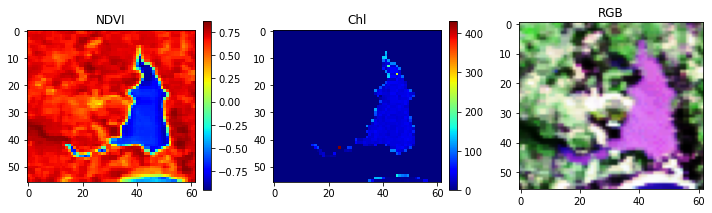

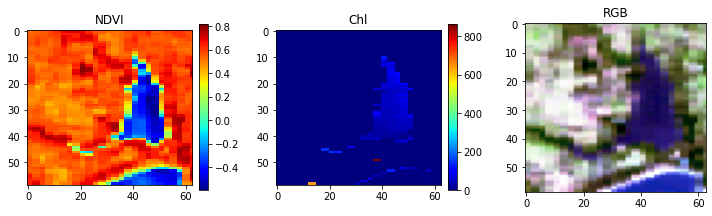

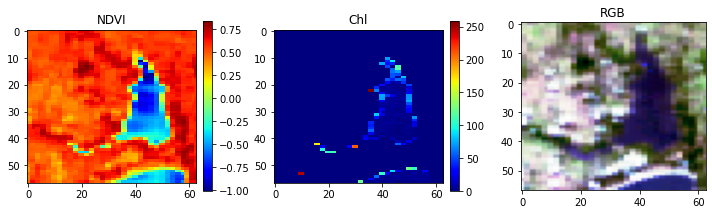

In [16]:
data_generator_chl_bottom = OLCIdataGenerator(DATA_PATH, dates_list=chl_bottom_days["date"].tolist(), skip_invalid=True)

for olci_data in data_generator_chl_bottom:
    if olci_data.date.date() == date and np.count_nonzero(olci_data.duplicated) > 1000:
        continue    
    date = olci_data.date.date()
    print(date)
    
    fig = plt.figure(figsize=(10,20))
    
    fig.add_subplot(131).title.set_text("NDVI")
    min_ndvi = np.amin(olci_data.mph.NDVI)
    max_ndvi = np.amax(olci_data.mph.NDVI)
    plt.imshow(olci_data.mph.NDVI, cmap='jet', interpolation='none',
              vmin=min_ndvi, vmax=max_ndvi)
    plt.colorbar(fraction=0.046, pad=0.04)    
    
    fig.add_subplot(132).title.set_text("Chl")
    min_chl = np.amin(olci_data.mph.chl)
    max_chl = np.amax(olci_data.mph.chl)
    plt.imshow(olci_data.mph.chl, cmap='jet', interpolation='none',
              vmin=min_chl, vmax=max_chl)
    plt.colorbar(fraction=0.046, pad=0.04)
    
    fig.add_subplot(133).title.set_text("RGB")
    plt.imshow(olci_data.rgb)
    fig.tight_layout()

## Trophic state detection

In [7]:
sampling_points_coords = {"SAUCE NORTE": [-34.795398, -55.047355],
                          "SAUCE SUR": [-34.843127, -55.064624],
                          "TA": [-34.829670, -55.049758]}

In [20]:
# create generator that yields instances of OLCIdata from dates with ground truth
# data corrupted by clouds is skipped
data_generator = OLCIdataGenerator(DATA_PATH, DATE_FORMAT, dates_list=all_gt_dates.tolist(), skip_invalid=True)

y_gt = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

y_pred = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

for olci_data in data_generator:
    # get gt data for same date as OLCI data
    day_fico_df = algae_df[algae_df["date"] == str(olci_data.date.date())]
    # iterate over rows, skipping unwanted gt data
    for index, row in day_fico_df.iterrows():
        if not (row["location"] in y_gt):
            continue
        olci_data._get_mph(0)
        olci_data.create_sparse_mask([sampling_points_coords[row["location"]]])
        
        immersed_mask = olci_data.mph.immersed_cyanobacteria*olci_data.mask
        count_immersed = np.count_nonzero(immersed_mask)
        
        floating_mask = olci_data.mph.floating_cyanobacteria*olci_data.mask
        count_floating = np.count_nonzero(olci_data.mph.floating_cyanobacteria*olci_data.mask)
        
        count_total = count_immersed + count_floating

        y_pred[row["location"]].append(count_total > 0)
        y_gt[row["location"]].append(True if row["label"] == "Bloom" else False)

SAUCE NORTE
Accuracy: 0.85
Precision: 0.6
Recall: 1.0
FPR: 0.0
FNR: 0.2


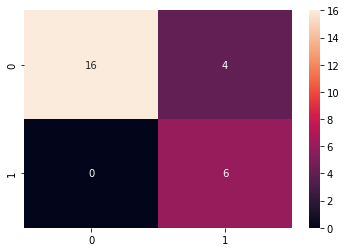

SAUCE SUR
Accuracy: 0.88
Precision: 0.73
Recall: 1.0
FPR: 0.0
FNR: 0.17


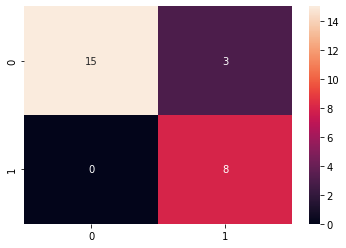

TA
Accuracy: 0.86
Precision: 0.77
Recall: 1.0
FPR: 0.0
FNR: 0.26


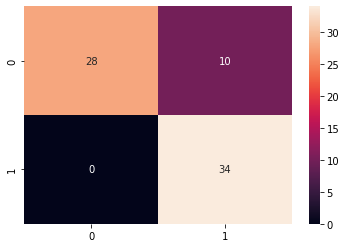

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def metrics(gt, pred):
    metrics = {}
    metrics["accuracy"] = round(accuracy_score(gt, pred), 2)
    metrics["precision"] = round(precision_score(gt, pred), 2)
    metrics["recall"] = round(recall_score(gt, pred), 2)
    metrics["confusion matrix"] = confusion_matrix(gt, pred)
    metrics["false positive rate"] = round(metrics["confusion matrix"][1, 0]/(metrics["confusion matrix"][1, 1] + metrics["confusion matrix"][1, 0]), 2)
    metrics["false negative rate"] = round(metrics["confusion matrix"][0, 1]/(metrics["confusion matrix"][0, 0] + metrics["confusion matrix"][0, 1]), 2)
    
    return metrics

for location in list(y_gt.keys()):
    print(location)
    m = metrics(y_gt[location], y_pred[location])
    print("Accuracy:", m["accuracy"])
    print("Precision:", m["precision"])
    print("Recall:", m["recall"])
    print("FPR:", m["false positive rate"])
    print("FNR:", m["false negative rate"])
    sns.heatmap(m["confusion matrix"], annot=True)
    plt.show()

### Create dataset using MPH input bands 

In [13]:
sentinel3_dataset_path = os.path.join(settings.final_data_path, "s3_brrs.json")

In [14]:
sentinel3_dataset = []
data_generator = OLCIdataGenerator(DATA_PATH, DATE_FORMAT, skip_invalid=False)
bands_names = ["rBRR_07", "rBRR_08", "rBRR_10", "rBRR_11", "rBRR_12", "rBRR_18"]

for olci_data in data_generator:
    dataset_entry = {}
    dataset_entry["date"] = str(olci_data.date.date())
    
    # set None as default for every sampling location data
    for location_name in sampling_points_coords.keys():
        dataset_entry[location_name] = {b_name: None for b_name in bands_names}
    
    # skip further processing for dates with clouds
    if olci_data.metadata["cloud level"] != "0":
        sentinel3_dataset.append(dataset_entry)
        continue
    
    # store 3x3 array of every band around location coords for days without clouds
    for location_name, location_coords in sampling_points_coords.items():
        i, j = olci_data.get_pos_index(location_coords[0], location_coords[1])
        for b_name in bands_names:
            dataset_entry[location_name][b_name] = olci_data.brrs_arrays[b_name][i-1:i+2, j-1:j+2].tolist()
    sentinel3_dataset.append(dataset_entry)
    

In [16]:
sentinel3_dataset[0:5]

[{'date': '2018-11-01',
  'SAUCE NORTE': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': None},
  'SAUCE SUR': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': None},
  'TA': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': None}},
 {'date': '2018-11-01',
  'SAUCE NORTE': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': None},
  'SAUCE SUR': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': None},
  'TA': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': None}},
 {'date': '2018-11-02',
  'SAUCE NORTE': {'rBRR_07': None,
   'rBRR_08': None,
   'rBRR_10': None,
   'rBRR_11': None,
   'rBRR_12': None,
   'rBRR_18': Non

In [17]:
import json

with open(sentinel3_dataset_path, "w") as outfile:
    json.dump(sentinel3_dataset, outfile)